# Step Matrix basic example

Step matrix is a very powerful tool in retentioneering arsenal. It allows to get quickly high-level understing of user behaviour. Step matrix has powerful customization options to tailor the output depending the goal of the analysis.

To better understand how step_matrix works let’s first consider intuitive example. Let’s say we are analyzing web-store logs and have dataset with event logs from four user sessions with the following events in following order:

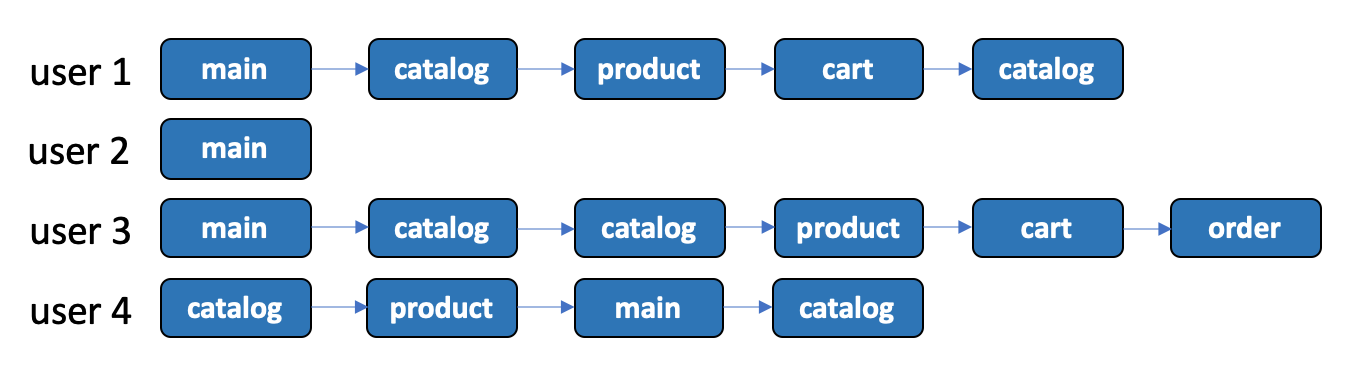

We can visualize this dataset as a heatmap indicating what fraction of users were at wich step in their trajectories:

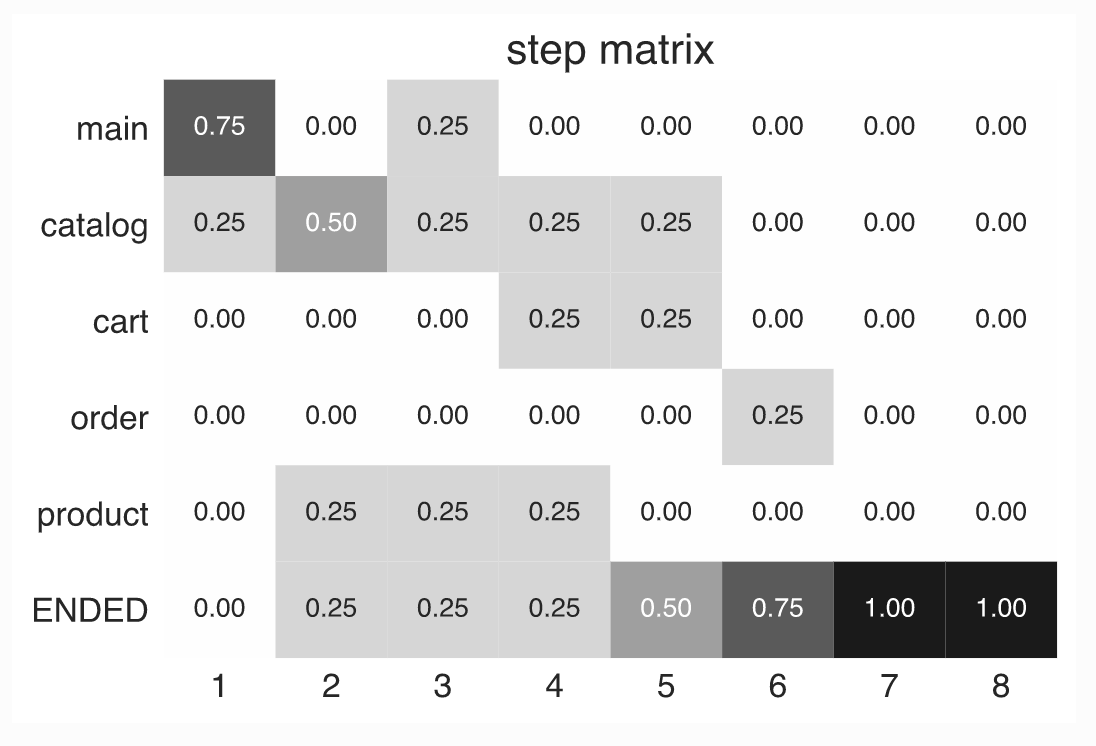

This is the simplest step matrix. It has individual unique events as a rows, columns corresponds to the positional number of event in user log and the value in the matrix shows what percentage users have given event at a given step. Note, that total value in each column is always 1 (all users must be at specific state at each step or have ENDED their trajectory).

Below we will explore how to plot and customize step matrix.

install retentioneering if running from google.colab or for the first time:

In [ ]:
!pip3 install retentioneering

## Basic example

To run examples below we need to import retentioneering, import sample dataset and update config to set names for the columns:

In [1]:
import retentioneering

# load sample data
data = retentioneering.datasets.load_simple_shop()

retentioneering.config.update({
    'user_col': 'user_id',
    'event_col':'event',
    'event_time_col':'timestamp',
})

To understand intuitively what is step_matrix let us begin with plotting step_matrix for extremely simple dataset containg events for only one user:

In [2]:
single_user = data[data['user_id']==613604495].reset_index(drop=True)
single_user

,user_id,event,timestamp
0,613604495,main,2019-11-02 23:25:03.672939
1,613604495,catalog,2019-11-02 23:25:07.390498
2,613604495,catalog,2019-11-02 23:25:48.043605
3,613604495,product2,2019-11-02 23:26:08.845033
4,613604495,cart,2019-11-02 23:26:37.007346
5,613604495,catalog,2019-11-02 23:26:38.406224
6,613604495,cart,2019-11-02 23:27:09.279245
7,613604495,catalog,2019-11-02 23:27:11.432713
8,613604495,product2,2019-11-02 23:27:43.193619
9,613604495,cart,2019-11-02 23:27:48.110186


Let’s plot a simple intuitive step_matrix for our single user dataset:

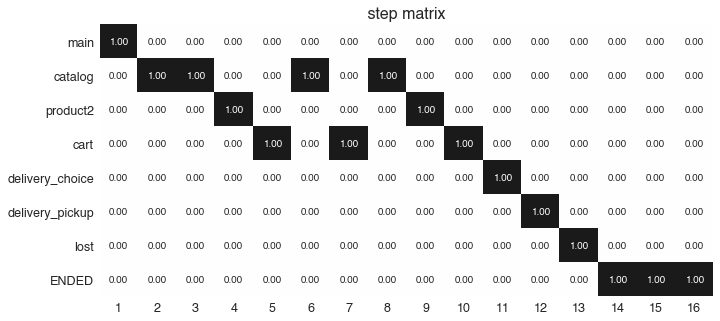

In [3]:
single_user.rete.step_matrix(max_steps=16);

We can see, since we have only one user in this example, step_matrix contains only 0’s and 1’s. At step 1 user had event main (100% of users have event main as first event in the trajecotry), then at step 2 user proceed to catalog, etc., etc., etc. By the step 13 user’s trajectory ended and there are no more events, therefore all subsequent events starting from step 13 are special events ENDED indicating no other events present.

Let’s now plot step_matrix for the full dataset containing all users:

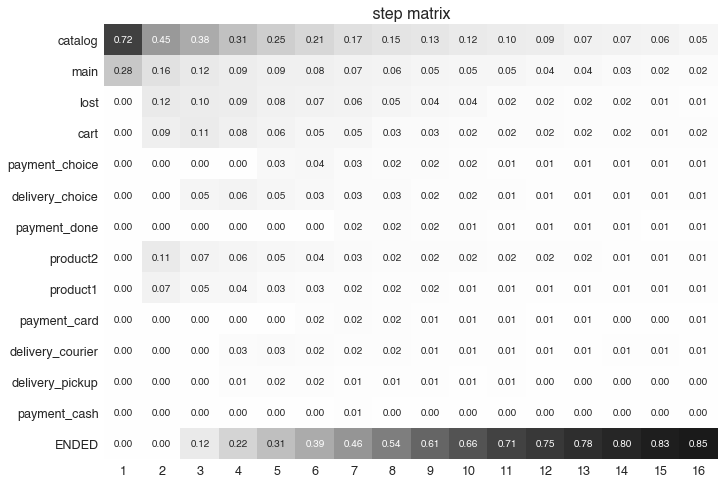

In [4]:
data.rete.step_matrix(max_steps=16);

By looking at the first column we can immediately say that users in the analyzed cohort start their sessions from events catalog (72%) and main (28%). At step 2 12% of users already ended their sessions and have no other events (row ENDED at step 2 is 0.12). We can see, that 52% of users finish their sessions with 6 or less events (row ENDED at step 7 is 0.52). Some conversions start happen after step 7 (row payment_done have 0.02 at step 7). And so on. Note, that at each step all values in every column always sum up to 1 (meaning that all users have some specific event or ENDED state). Below we will explore other options for step_matrix function to make the output much more informative and tailored for the goals of particular analysis.

## Thresholding

When we plot step_matrix using full dataset sometimes we want first focus on bigger picture and avoid rows with event where insignificant fraction of users was present. Such thresholding can be done using thresh parameter (float, default: 0). If the row has all values less than specified thresh, such row will not be shown.



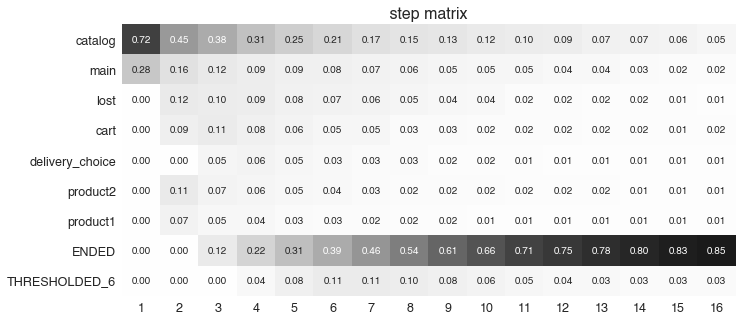

In [5]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05);

All events cutted away by thresholding are grouped together in THRESHOLDED_X row, where X - is the total number of dropped events.



## Targets analysis

Very often there are specific events of particular importance for product analyst (for example such as cart, or order_confirmed, or subscribe, etc.). Often such events have much lower occurrence rate comparing other events (like main page or catalog) and often ended up thresholded from step_matrix or shown with non-informative coloring. In this case we can isolate those events of particular importance (targets) to individual rows, each of which will have their individual color scale. This can be done with parameter targets:

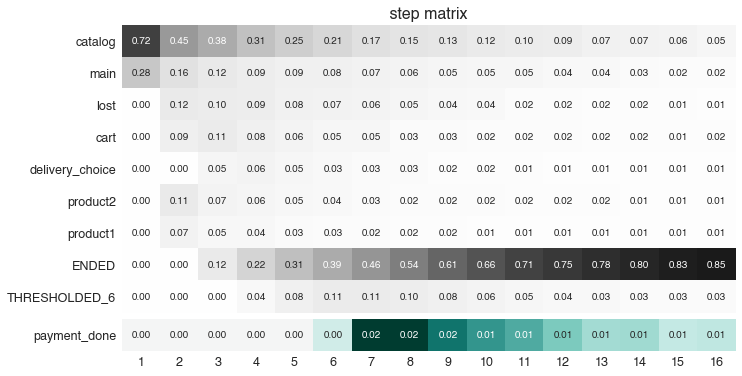

In [6]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['payment_done']);

Specified target events are always shown in the bottom of step matrix regardless of selected threshold. Multiple targets can be included as a list:

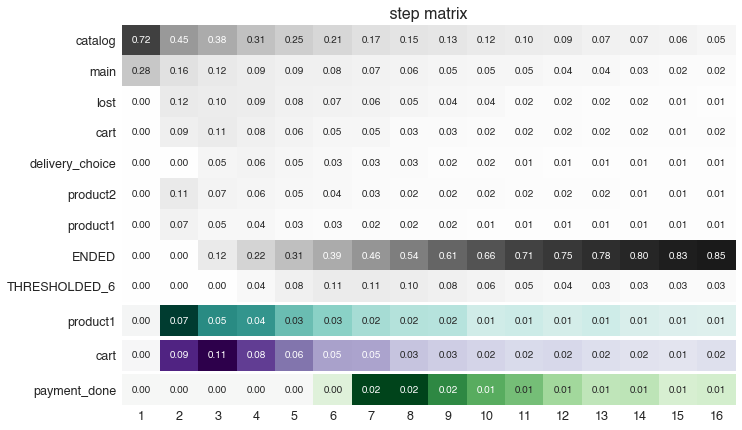

In [7]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1','cart','payment_done']);

If we want to compare some targets and plot them using same color scaling, we can combine them in sub-list inside the targets list:

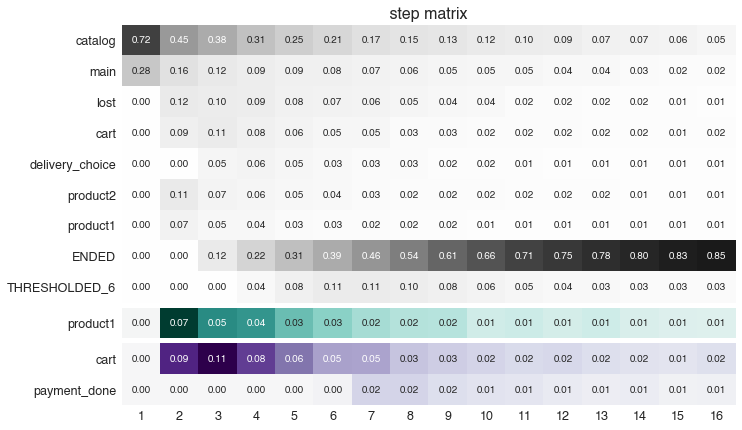

In [8]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']]);

Now we can visually compare by color how mamy users reach cart vs payment_done at particular step in their trajectory.

Targets can be presented as accumulated values (or both):

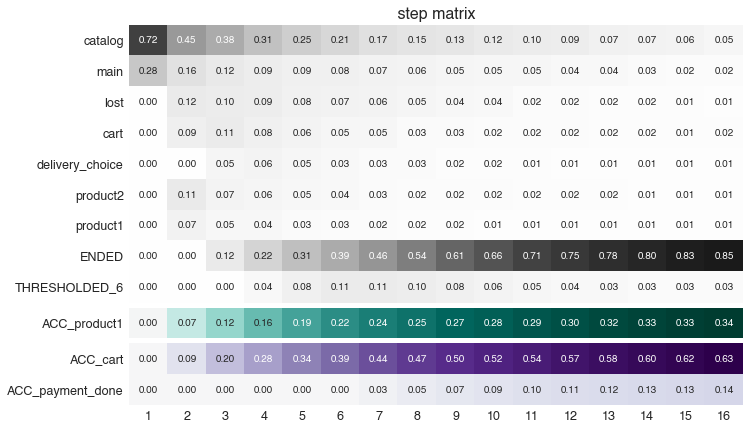

In [9]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']],
                      accumulated='only');

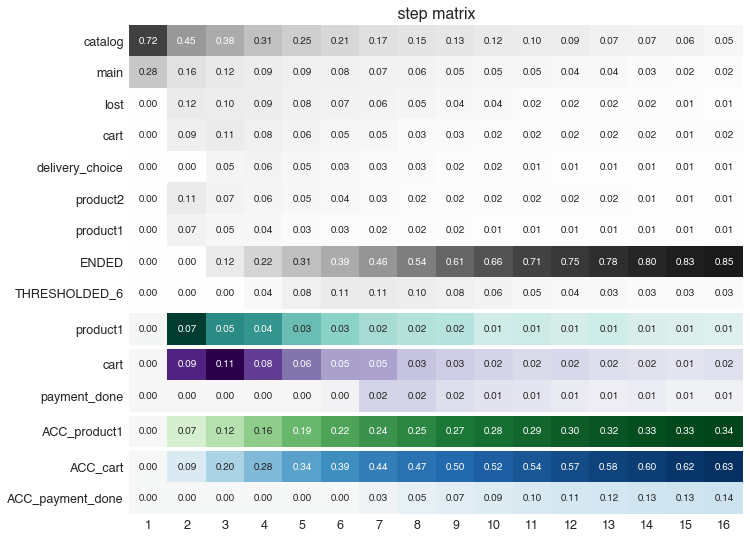

In [10]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']],
                      accumulated='both');

## Centered step matrix

Sometimes we are interested in flow of users through specific event: how do users reach specific event and what do they do after? This information can be visualized with step_marix using parameter centered:

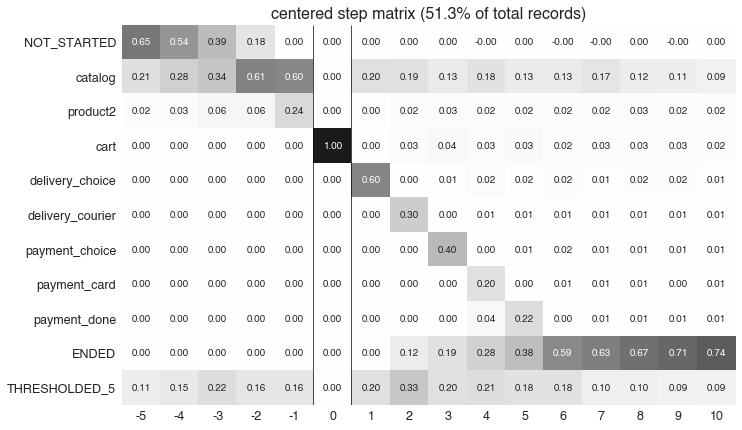

In [11]:
data.rete.step_matrix(max_steps=16,
                      thresh = 0.2,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1});

Note, that when plot step_matrix with parameter centered we only keep users who have reached specified event (the column 0 has value 1 at specified event). Parameter centered is a dictionary wich requires three keys:

* ‘event’ - name of the event we are interested. This event will be taken as 0. Negative step numbers will corresponds to events before selected event and positive step numbers will correspond to steps after selected event.

* ‘left_gap’ - integer number which indicates how much steps before centered event we want to show on step matrix

* ‘occurrence’ - which occurrence number of target event we are interested in. For example, if in the example above, all trajectories will be aligned to have first ‘cart’ occurrence as step 0.

Importantly, when centered step matrix is used, only users who have selected event in their trajectories present (or it’s n`th occurrence) will be shown. Therefore, the column with step index 0 will always have 1 at selected event and zero at all other events. Fraction of users kept for centered step matrix shown in the title. In the example above, 51.3% of users have reach event ‘cart’ at least once.

We can use all targets functionality with centered step_matrix, for example:

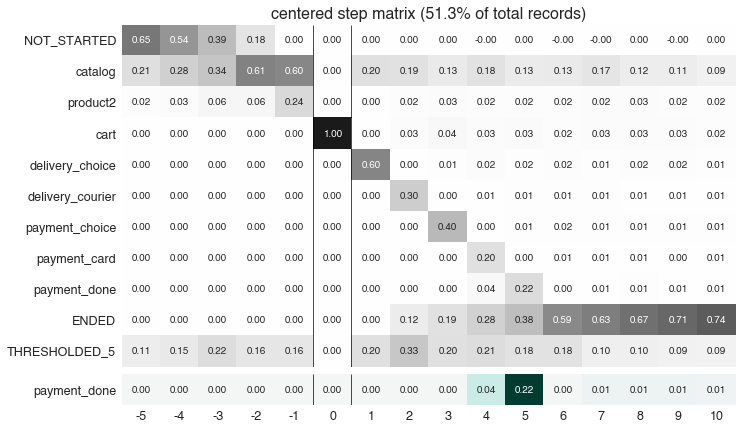

In [12]:
data.rete.step_matrix(max_steps=16,
                      thresh = 0.2,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      targets=['payment_done']);

# Custom events sorting

Sometimes it is needed to obtain step_matrix with events listed in the specific order (for example, to compare two step_matrixes). This can be done with parameter sorting which accepts list of event names in the required order to show up in the step matrix. For convenience, to obtain list of event names from the most recent step_matrix output you can always refer to retentioneering.config[‘step_matrix’][‘sorting’] after each step_matrix run. Let’s consider an example:

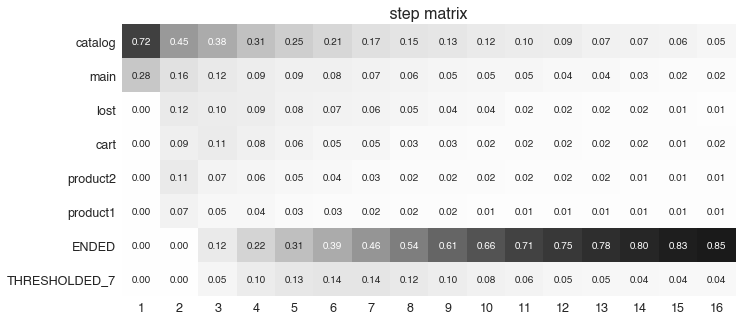

In [13]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.07);

Let’s say we would like to change the order of the events in the resulted step_matrix. First, we can obtain list of event names from the last step_matrix output using retentioneering.config:

In [14]:
print(retentioneering.config['step_matrix']['sorting'])

['catalog', 'main', 'lost', 'cart', 'product2', 'product1', 'ENDED', 'THRESHOLDED_7']


Now we can conveniently copy the list of events, reorganize it in the required order and pass to step_matrix function as sorting parameter:

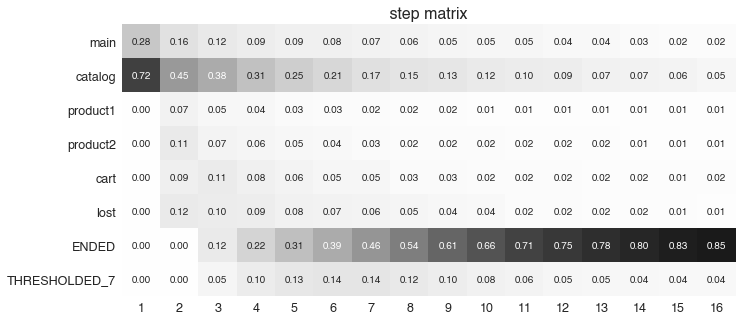

In [15]:
custom_order = ['main',
                'catalog', 
                'product1',                
                'product2',                
                'cart',
                'lost',                
                'ENDED',
                'THRESHOLDED_7']

data.rete.step_matrix(max_steps=16,
                      thresh=0.07,
                      sorting=custom_order);

Note, that ordering only affects non-target events. Target events will always be in the same order as they are specified in the parameter targets.

# Differential step_matrix

Sometimes we need to compare behavior of several groups of users. For example, when we would like to compare behavior of users who had conversion to target vs. who had not, or compare behavior of test and control groups in A/B test, or compare behavior between specific segments of users.

In this case it is informative to plot a step_matrix as difference between step_matrix for group_A and step_matrix for group_B. This can be done using parameter groups, which requires a tuple of two elements (g1 and g2): where g_1 and g_2 are collections of user_id`s (list, tuple or set). Two separate step_matrixes M1 and M2 will be calculated for users from g_1 and g_2, respectively. Resulting matrix will be the matrix M = M1-M2. Note, that values in each column in differential step matrix will always sum up to 0 (since columns in both M1 and M2 always sum up to 1).

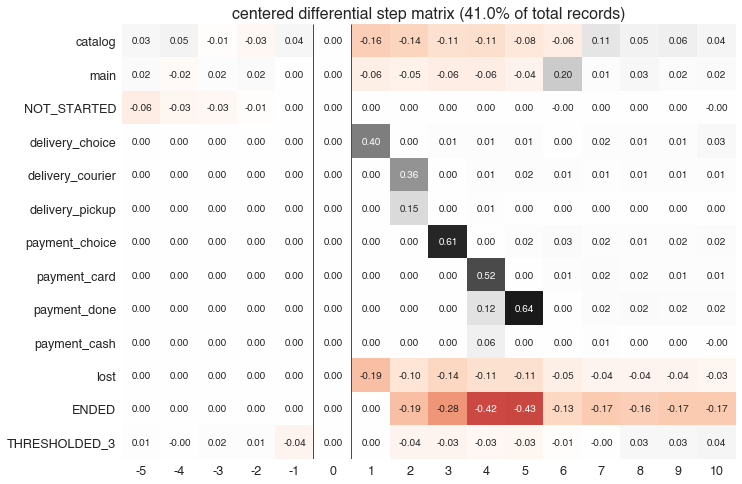

In [16]:
g1 = set(data[data['event']=='payment_done']['user_id'])
g2 = set(data['user_id']) - g1

data.rete.step_matrix(max_steps=16,
                      thresh = 0.05,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      groups=(g1, g2));

Let’s consider another example of differential step matrix use, where we will compare behavior of two user clusters. First, let’s obtain behavioural segments and visualize the results of segmentation using conversion to ‘payment_done’ and event ‘cart’ (to learn more about user behavior clustering read here):

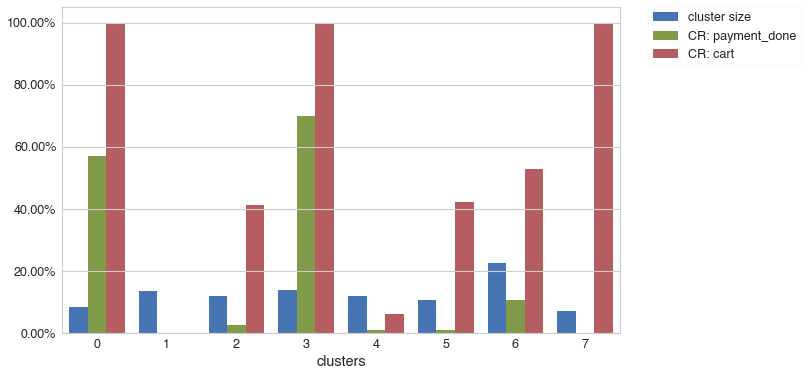

In [17]:
data.rete.get_clusters(plot_type='cluster_bar',
                       targets=['payment_done', 'cart'],
                       refit_cluster=True);

We can see 8 clusters with the corresponding conversion rates to specified events (% of users in the given cluster who had at least one specified event). Let’s say we would like to compare behavior segments 3 and 7. Both have relatively high conversion rate and cart visit rate. Let’s find out how they are differ using differential step_matrix. All we need is to get user_id’s collections from cluster_mapping attribute and pass it to groups parameter of step_matrix:

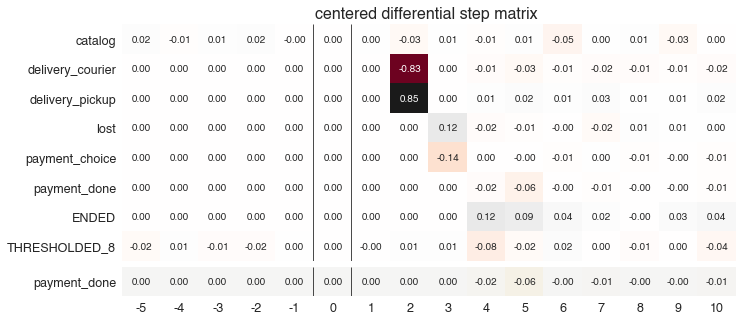

In [18]:
g1 = data.rete.cluster_mapping[0]
g2 = data.rete.cluster_mapping[3]

data.rete.step_matrix(max_steps=16,
                      thresh = 0.05,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      groups=(g1, g2),
                      targets = ['payment_done']);

We can clearly see that these two behavioural segments are quite similar to each other with the only strong difference at the second step after ‘cart’ event: users of segment 3 prefer to select ‘delivery_courier’ (large positive value), and users of segment 7 prefer to select ‘delivery_pickup’ (large negative value).